In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from matplotlib import cm, pyplot as plt
from hmmlearn.hmm import GaussianHMM
import scipy 
import datetime
import json
import seaborn as sns
import joblib
import os
import matplotlib.cm as cm
import swifter
import pickle
import pycatflow as pcf
import dtale
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from tsfresh import extract_features,select_features
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 读取数据

In [3]:
i = 0
res = None
for resdir in os.listdir('D:\\BaiduNetdiskDownload\\20211021永续\\swap'):
    info = os.path.join('D:\\BaiduNetdiskDownload\\20211021永续\swap',resdir)
    info = os.path.join(info, 'BTC-USDT_5m.csv')
    f = open(info)
    temp = pd.read_csv(f, header = 1)
    if i == 0:
        res = temp
    else:
        res = pd.concat([res, temp])
    i = i + 1

res = res.reset_index(drop=True)
res['candle_begin_time'] = pd.to_datetime(res['candle_begin_time'])
res.set_index(["candle_begin_time"], inplace=True)     
res.sort_index(inplace=True)

# 数据清洗

#### 检查数据是否是真实过程[数据正确性大于数据完整性]

原则1：数据的正确性大于完整性,可以不存，但是一定要正确

原则2：如果实在拿不到正确数据就不存

1、从数据源1拿到ohlcv记为quote1

2、从数据源2拿到ohlcv记为quote2

3、若quote1等于quote2，则认为该数据正确

4、若quote1不等于quote2，则继续从数据源3拿到ohlcv记为quote3

5、若quote1等于quote3，则存quote1，否则，若quote2等于quote3，则存quote2

6、若三个quote都互不相等，则记为空，即遵循数据处理原则1

对每个Bar的open、close、high、low、volume等数据都应该重复这个步骤(异常值在上述步骤被发现)


[上述的等于都替换成误差在一定范围内]

#### 检查数据是否缺失 

In [4]:
#  '2019-09-09 01:00:00', '2019-09-09 01:05:00',
#  '2019-09-09 02:50:00', '2019-09-09 02:55:00',
#   数据缺失
time_delta = datetime.timedelta(minutes=5)
begin_time = datetime.datetime(2019, 9, 8, 19, 5, 0)
for time in res.index:
    if begin_time + time_delta == time:
        begin_time = time
    else:
        print(time)
        begin_time = time

2019-09-08 17:55:00


#### 对缺失的数据进行处理

#### 检查数据是否存在重复

In [5]:
# 无重复数据
time_delta = datetime.timedelta(minutes=5)
begin_time = datetime.datetime(2019, 9, 8, 19, 10, 0)
for time in res.index[1:]:
    if begin_time == time:
        print(time)
    else:
        begin_time = time

#### 对重复的数据进行处理 

#### 对某些特征进行平滑处理

In [6]:
# res['smooth_0.5']= res.open.ewm(alpha =0.5).mean()
# res['smooth_0.9']= res.open.ewm(alpha =0.9).mean()

# EDA

1、对特征进行相关性分析

2、如有标签，对特征及标签进行相关性分析

3、对每个特征进行统计检验

4、对各个标签分别进行统计检验


<b>addition:</b>

1、做出各种假设：
如 Time Series Data = Seasonal + Random or Trend + Random

2、我想要找到各个state或者各个特征是否有时间模式

3、我想要找到适合的时间分辨率

4、相关性分析的同时注意虚假相关性的出现



#### 可视化数据的空值

<AxesSubplot:ylabel='candle_begin_time'>

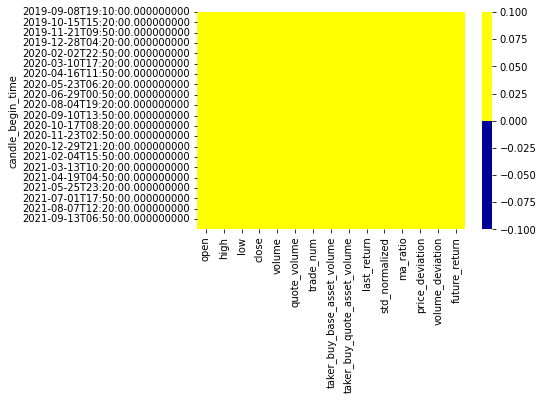

In [95]:
cols = res.columns 
colours = ['#000099', '#ffff00'] 
sns.heatmap(res[cols].isnull(), cmap=sns.color_palette(colours))

#### 可视化特征之间相关性

<AxesSubplot:>

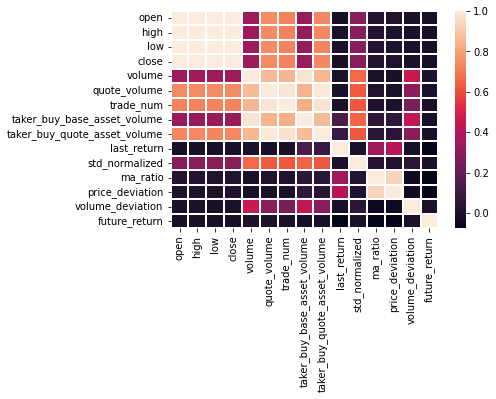

In [101]:
sns.heatmap(res.corr('spearman'),linewidths=0.1)

#### 有标签时，画出相关性大的特征的时间序列与标签的时间序列

In [ ]:
fig=plt.figure(figsize=(60,20))
plt.plot(res.index,res['feature'],label='feature')
plt.plot(res.index,resf['state'],label='state')
plt.xlabel('time')
plt.ylabel('change')
plt.legend(loc='best')

#### 检查各个特征以及输出的时间序列是否具有平稳性

大量的统计学模型基于平稳性的假设。
对于一个应用于非平稳时间序列的模型，它的准确性和模型指标会随着时间序列本身变化而变化，从而造成模型本身不稳定
强平稳性要求数据的分布不随时间变化，而弱平稳性仅仅要求数据的一阶距和二阶矩（均值和方差）不随时间变化

[下述采用ADF检验（基于单位根）]

<AxesSubplot:title={'center':'open price Series'}, xlabel='candle_begin_time'>

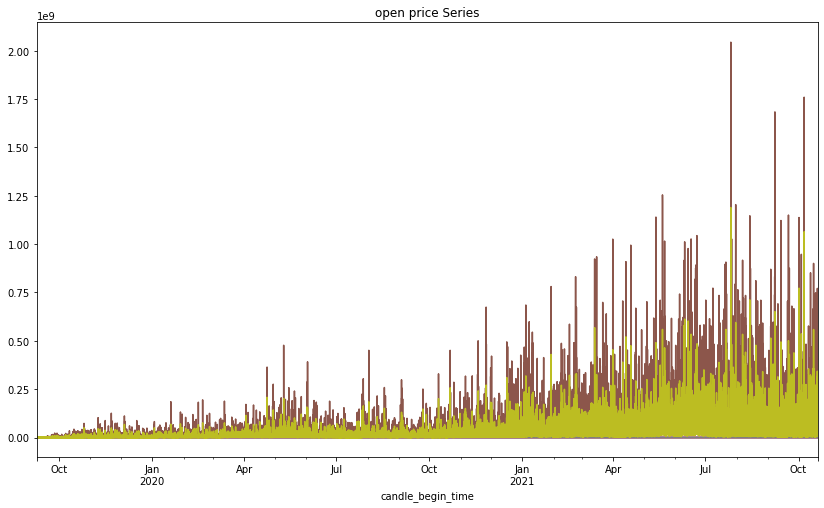

In [12]:
series = res.loc[:, 'open'].values
res.plot(figsize=(14,8), legend=None, title='open price Series')

In [13]:
result = adfuller(series, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')

ADF Statistic: 0.24565394149715997
n_lags: 0.9747090319737114
p-value: 0.9747090319737114


#### 按月进行分析，画出时序图 

In [105]:
fig = plt.figure(figsize=(100,100))
def plot_every_month(begin_datetime, end_datetime):
    time_delta = datetime.timedelta(months=1)
    plt.title("The time series of feature and label for every month")
    
    while begin_datetime < end_datetime:
        plt.subplot(50,1,i)
        data = res[(res.index >= begin_datetime) & (res.index < begin_datetime + time_delta)]
        plt.plot(data1.index, data1['feature'],label='feature')
        plt.plot(data1.index, data1['state'],label='state')
        plt.legend()
        i += 1
        begin_datetime += time_delta
        
    plt.xlabel("Time")
    plt.ylabel("change")
    plt.show()

<Figure size 7200x7200 with 0 Axes>

#### 按季度进行分析，画出时序图 


In [106]:
fig = plt.figure(figsize=(100,100))
def plot_every_month(begin_datetime, end_datetime):
    time_delta = datetime.timedelta(months=3)
    plt.title("The time series of feature and label for every month")
    
    while begin_datetime < end_datetime:
        plt.subplot(20,1,i)
        data = res[(res.index >= begin_datetime) & (res.index < begin_datetime + time_delta)]
        plt.plot(data1.index, data1['feature'],label='feature')
        plt.plot(data1.index, data1['state'],label='state')
        plt.legend()
        i += 1
        begin_datetime += time_delta
        
    plt.xlabel("Time")
    plt.ylabel("change")
    plt.show()

<Figure size 7200x7200 with 0 Axes>

#### 按weekday进行分析，看每个weekday的state分布

In [110]:
fig = plt.figure(figsize=(100,100))
def plot_weekday(begin_datetime, end_datetime):
    pass

<Figure size 7200x7200 with 0 Axes>

#### 分析自相关性以及偏自相关性

描述的是一组时间序列和它前面间隔n个时刻的一组时间序列之前的相关性

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

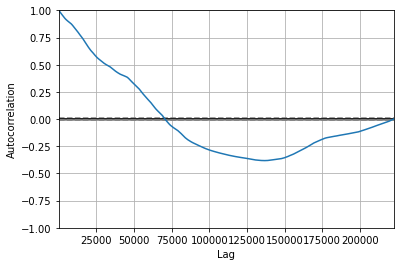

In [18]:
pd.plotting.autocorrelation_plot(res['open']) 
pd.plotting.lag_plot(res['open'],lag=12)

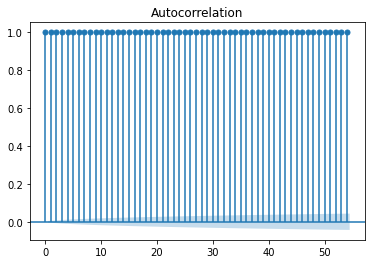

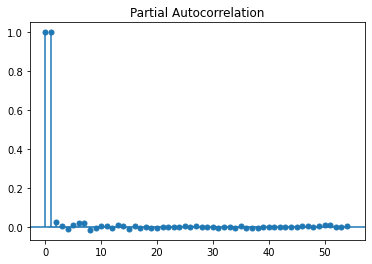

In [17]:
series = res.loc[:, 'open'].values
plot_acf(series)
plot_pacf(series)
plt.show()

#### 找出是否有季节性与趋势性特征

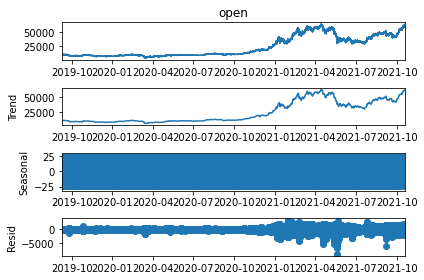

In [54]:
decomposed = seasonal_decompose(res['open'], model='additive',freq = 4 * 24 *3)
x = decomposed.plot()

#### 对趋势项和季节项特征进行处理

#### 检查离群值

In [113]:
def out_iqr(s, k=1.5, return_thresholds=False):
    # calculate interquartile range
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return [True if x < lower or x > upper else False for x in s]
    
# For comparison, make one array each at varying values of k.
iqr1 = res.apply(out_iqr, k=1.5)
iqr1.head(10)

,open,high,low,close,volume,quote_volume,trade_num,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,last_return,std_normalized,ma_ratio,price_deviation,volume_deviation,future_return
candle_begin_time,,,,,,,,,,,,,,,
2019-09-08 19:10:00,False,False,False,False,False,False,False,False,False,True,True,True,False,True,False
2019-09-08 19:15:00,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False
2019-09-08 19:20:00,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False
2019-09-08 19:25:00,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False
2019-09-08 19:30:00,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False
2019-09-08 19:35:00,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False
2019-09-08 19:40:00,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False
2019-09-08 19:45:00,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False
2019-09-08 19:50:00,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False


#### 检查异常值

In [1]:
def plot_abnormal():   
    fig=plt.figure(figsize=(12,5))
    ax=plt.subplot(1,2,1)
    # sns.boxplot(x='',y='',data=res)
    pass

#### 处理离群值

In [112]:
def process_outlier():
    pass

#### 提供missing value、相关系数等自动分析

In [73]:
d = dtale.show(res)
d.open_browser()

Exception occurred while processing request: Dataset exceeds 15000 records, cannot render. Please apply filter...
Traceback (most recent call last):
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 114, in _handle_exceptions
    return func(*args, **kwargs)
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 2873, in get_correlations_ts
    return_data, _code = build_base_chart(data.fillna(0), "date", "corr", agg="raw")
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 933, in build_base_chart
    data_limit=data_limit,
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 402, in check_exceptions
    raise ChartBuildingError(limit_msg.format(data_limit))
dtale.utils.ChartBuildingError: Chart Error


2021-11-15 15:49:10,161 - ERROR    - Exception occurred while processing request: Dataset exceeds 15000 records, cannot render. Please apply filter...
Traceback (most recent call last):
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 114, in _handle_exceptions
    return func(*args, **kwargs)
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 2873, in get_correlations_ts
    return_data, _code = build_base_chart(data.fillna(0), "date", "corr", agg="raw")
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 933, in build_base_chart
    data_limit=data_limit,
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 402, in check_exceptions
    raise ChartBuildingError(limit_msg.format(data_limit))
dtale.utils.ChartBuildingError: Chart Error


Exception occurred while processing request: Dataset exceeds 15000 records, cannot render. Please apply filter...
Traceback (most recent call last):
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 114, in _handle_exceptions
    return func(*args, **kwargs)
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 2873, in get_correlations_ts
    return_data, _code = build_base_chart(data.fillna(0), "date", "corr", agg="raw")
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 933, in build_base_chart
    data_limit=data_limit,
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 402, in check_exceptions
    raise ChartBuildingError(limit_msg.format(data_limit))
dtale.utils.ChartBuildingError: Chart Error


2021-11-15 15:49:15,256 - ERROR    - Exception occurred while processing request: Dataset exceeds 15000 records, cannot render. Please apply filter...
Traceback (most recent call last):
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 114, in _handle_exceptions
    return func(*args, **kwargs)
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 2873, in get_correlations_ts
    return_data, _code = build_base_chart(data.fillna(0), "date", "corr", agg="raw")
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 933, in build_base_chart
    data_limit=data_limit,
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 402, in check_exceptions
    raise ChartBuildingError(limit_msg.format(data_limit))
dtale.utils.ChartBuildingError: Chart Error


Exception occurred while processing request: Dataset exceeds 15000 records, cannot render. Please apply filter...
Traceback (most recent call last):
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 114, in _handle_exceptions
    return func(*args, **kwargs)
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 2873, in get_correlations_ts
    return_data, _code = build_base_chart(data.fillna(0), "date", "corr", agg="raw")
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 933, in build_base_chart
    data_limit=data_limit,
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 402, in check_exceptions
    raise ChartBuildingError(limit_msg.format(data_limit))
dtale.utils.ChartBuildingError: Chart Error


2021-11-15 15:49:17,426 - ERROR    - Exception occurred while processing request: Dataset exceeds 15000 records, cannot render. Please apply filter...
Traceback (most recent call last):
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 114, in _handle_exceptions
    return func(*args, **kwargs)
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 2873, in get_correlations_ts
    return_data, _code = build_base_chart(data.fillna(0), "date", "corr", agg="raw")
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 933, in build_base_chart
    data_limit=data_limit,
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 402, in check_exceptions
    raise ChartBuildingError(limit_msg.format(data_limit))
dtale.utils.ChartBuildingError: Chart Error


Exception occurred while processing request: Dataset exceeds 15000 records, cannot render. Please apply filter...
Traceback (most recent call last):
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 114, in _handle_exceptions
    return func(*args, **kwargs)
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 2873, in get_correlations_ts
    return_data, _code = build_base_chart(data.fillna(0), "date", "corr", agg="raw")
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 933, in build_base_chart
    data_limit=data_limit,
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 402, in check_exceptions
    raise ChartBuildingError(limit_msg.format(data_limit))
dtale.utils.ChartBuildingError: Chart Error


2021-11-15 15:49:20,956 - ERROR    - Exception occurred while processing request: Dataset exceeds 15000 records, cannot render. Please apply filter...
Traceback (most recent call last):
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 114, in _handle_exceptions
    return func(*args, **kwargs)
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 2873, in get_correlations_ts
    return_data, _code = build_base_chart(data.fillna(0), "date", "corr", agg="raw")
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 933, in build_base_chart
    data_limit=data_limit,
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 402, in check_exceptions
    raise ChartBuildingError(limit_msg.format(data_limit))
dtale.utils.ChartBuildingError: Chart Error


Exception occurred while processing request: Dataset exceeds 15000 records, cannot render. Please apply filter...
Traceback (most recent call last):
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 114, in _handle_exceptions
    return func(*args, **kwargs)
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 2873, in get_correlations_ts
    return_data, _code = build_base_chart(data.fillna(0), "date", "corr", agg="raw")
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 933, in build_base_chart
    data_limit=data_limit,
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 402, in check_exceptions
    raise ChartBuildingError(limit_msg.format(data_limit))
dtale.utils.ChartBuildingError: Chart Error


2021-11-15 15:49:24,831 - ERROR    - Exception occurred while processing request: Dataset exceeds 15000 records, cannot render. Please apply filter...
Traceback (most recent call last):
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 114, in _handle_exceptions
    return func(*args, **kwargs)
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 2873, in get_correlations_ts
    return_data, _code = build_base_chart(data.fillna(0), "date", "corr", agg="raw")
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 933, in build_base_chart
    data_limit=data_limit,
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 402, in check_exceptions
    raise ChartBuildingError(limit_msg.format(data_limit))
dtale.utils.ChartBuildingError: Chart Error


Exception occurred while processing request: Dataset exceeds 15000 records, cannot render. Please apply filter...
Traceback (most recent call last):
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 114, in _handle_exceptions
    return func(*args, **kwargs)
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 2873, in get_correlations_ts
    return_data, _code = build_base_chart(data.fillna(0), "date", "corr", agg="raw")
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 933, in build_base_chart
    data_limit=data_limit,
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 402, in check_exceptions
    raise ChartBuildingError(limit_msg.format(data_limit))
dtale.utils.ChartBuildingError: Chart Error


2021-11-15 15:49:25,164 - ERROR    - Exception occurred while processing request: Dataset exceeds 15000 records, cannot render. Please apply filter...
Traceback (most recent call last):
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 114, in _handle_exceptions
    return func(*args, **kwargs)
  File "D:\anaconda\envs\work\lib\site-packages\dtale\views.py", line 2873, in get_correlations_ts
    return_data, _code = build_base_chart(data.fillna(0), "date", "corr", agg="raw")
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 933, in build_base_chart
    data_limit=data_limit,
  File "D:\anaconda\envs\work\lib\site-packages\dtale\charts\utils.py", line 402, in check_exceptions
    raise ChartBuildingError(limit_msg.format(data_limit))
dtale.utils.ChartBuildingError: Chart Error


#### 查看类别特征随着时间的变化

In [ ]:
data = None
viz = pcf.visualize(data, spacing=20, width=800, maxValue=20, minValue=2)
viz

# 特征工程 

<h3>数据预处理的一些手段</h3>

 1、除最大值
 
 2、MinMax
 
 3、y = log(1+x)
 
 4、除以均值
 
 5、QuantileTransformer
 
 6、GaussianRank
 
 7、standardscaler
        
<h3>构建特征的一些手段</h3>

1、增加离散特征

2、通过错误分析发现新的特征（查看模型在哪里分类错误）

3、特征组合


<h3>目标</h3>

1、尽量得到一些具有平稳性的特征

2、AutoFE



In [7]:
# feature params
future_period = 1
std_period = 15
ma_period = 15
price_deviation_period = 15
volume_deviation_period = 15

# feature columns
cols_features = ['last_return', 'std_normalized', 'ma_ratio', 'price_deviation', 'volume_deviation']

In [8]:
def std_normalized(vals):
    return np.std(vals) / np.mean(vals)

def ma_ratio(vals):
    return (vals[-1] - np.mean(vals)) / vals[-1]

def values_deviation(vals):
    return (vals[-1] - np.mean(vals)) / np.std(vals)


<h3>流动性特征构建【交易量/流动性和波动性有显著相关性】</h3>

f(x) = -bid_size * log(x - bid_price) - ask_size * log(ask_price - x)
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; x ∈ [bid_price, ask_price]  &nbsp;&nbsp;&nbsp;&nbsp;wap=argmin(f(x))

liq<sub>1</sub> = sum<sub>i</sub>[bid_size<sub>i</sub>/wap<sub>i</sub>-bid_price<sub>i</sub>&nbsp;&nbsp;+ask_size<sub>i</sub>/ask_price<sub>i</sub>-wap<sub>i</sub>]

new_feature = Trade Volume / liq<sub>1</sub>


#### 自动生成时序特征并进行选择

In [7]:
tempres = res.reset_index()
tempres['id'] = [1 for i in range(len(tempres))] # 这里可以之后可以加入用其他币种一起提取特征

In [6]:
X_extracted = extract_features(tempres[:100],column_id = 'id',column_sort = "candle_begin_time")
X_extracted

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.76s/it]


,high__variance_larger_than_standard_deviation,high__has_duplicate_max,high__has_duplicate_min,high__has_duplicate,high__sum_values,high__abs_energy,high__mean_abs_change,high__mean_change,high__mean_second_derivative_central,high__median,...,taker_buy_quote_asset_volume__permutation_entropy__dimension_5__tau_1,taker_buy_quote_asset_volume__permutation_entropy__dimension_6__tau_1,taker_buy_quote_asset_volume__permutation_entropy__dimension_7__tau_1,taker_buy_quote_asset_volume__query_similarity_count__query_None__threshold_0.0,"taker_buy_quote_asset_volume__matrix_profile__feature_""min""__threshold_0.98","taker_buy_quote_asset_volume__matrix_profile__feature_""max""__threshold_0.98","taker_buy_quote_asset_volume__matrix_profile__feature_""mean""__threshold_0.98","taker_buy_quote_asset_volume__matrix_profile__feature_""median""__threshold_0.98","taker_buy_quote_asset_volume__matrix_profile__feature_""25""__threshold_0.98","taker_buy_quote_asset_volume__matrix_profile__feature_""75""__threshold_0.98"
1,1.0,0.0,1.0,1.0,1031993.55,1.065195e+10,6.684545,3.955859,0.0,10376.585,...,0.488238,0.564281,0.626805,NaN,10.999519,11.776211,11.457327,11.378162,11.378162,11.666377


In [9]:
# 按一定条件生成特征
# fc_parameters = {
#     "length": None,
#     "large_standard_deviation": [{"r": 0.05}, {"r": 0.1}]
# }
# extract_features(tempres, column_id = "id",column_sort = "candle_begin_time",default_fc_parameters=fc_parameters)

In [10]:
# X_extracted_cols = X_extracted.isnull().sum().where(lambda x : x==0).dropna().index  # 由于不是所有生成的变量都是有意义的，删除掉包含NA的特征，这也是特征选择函数的要求
# X_selected = select_features(X_extracted[X_extracted_cols], y)
# print('count of raw feature: {}'.format(len(X_extracted_cols)))
# print('count of auto-selected feature: {}'.format(len(X_selected.columns)))

#### 暂时用的一些基本特征

In [5]:
res['last_return'] = res['close'].pct_change()
res['std_normalized'] = res['close'].rolling(std_period).apply(std_normalized)
res['ma_ratio'] = res['close'].rolling(ma_period).apply(ma_ratio)
res['price_deviation'] = res['close'].rolling(price_deviation_period).apply(values_deviation)
res['volume_deviation'] = res['volume'].rolling(volume_deviation_period).apply(values_deviation)
res['future_return'] = res['close'].pct_change(future_period).shift(-future_period)
res = res.replace([np.inf, - np.inf], np.nan)
res = res.dropna()

<Figure size 1440x7200 with 0 Axes>

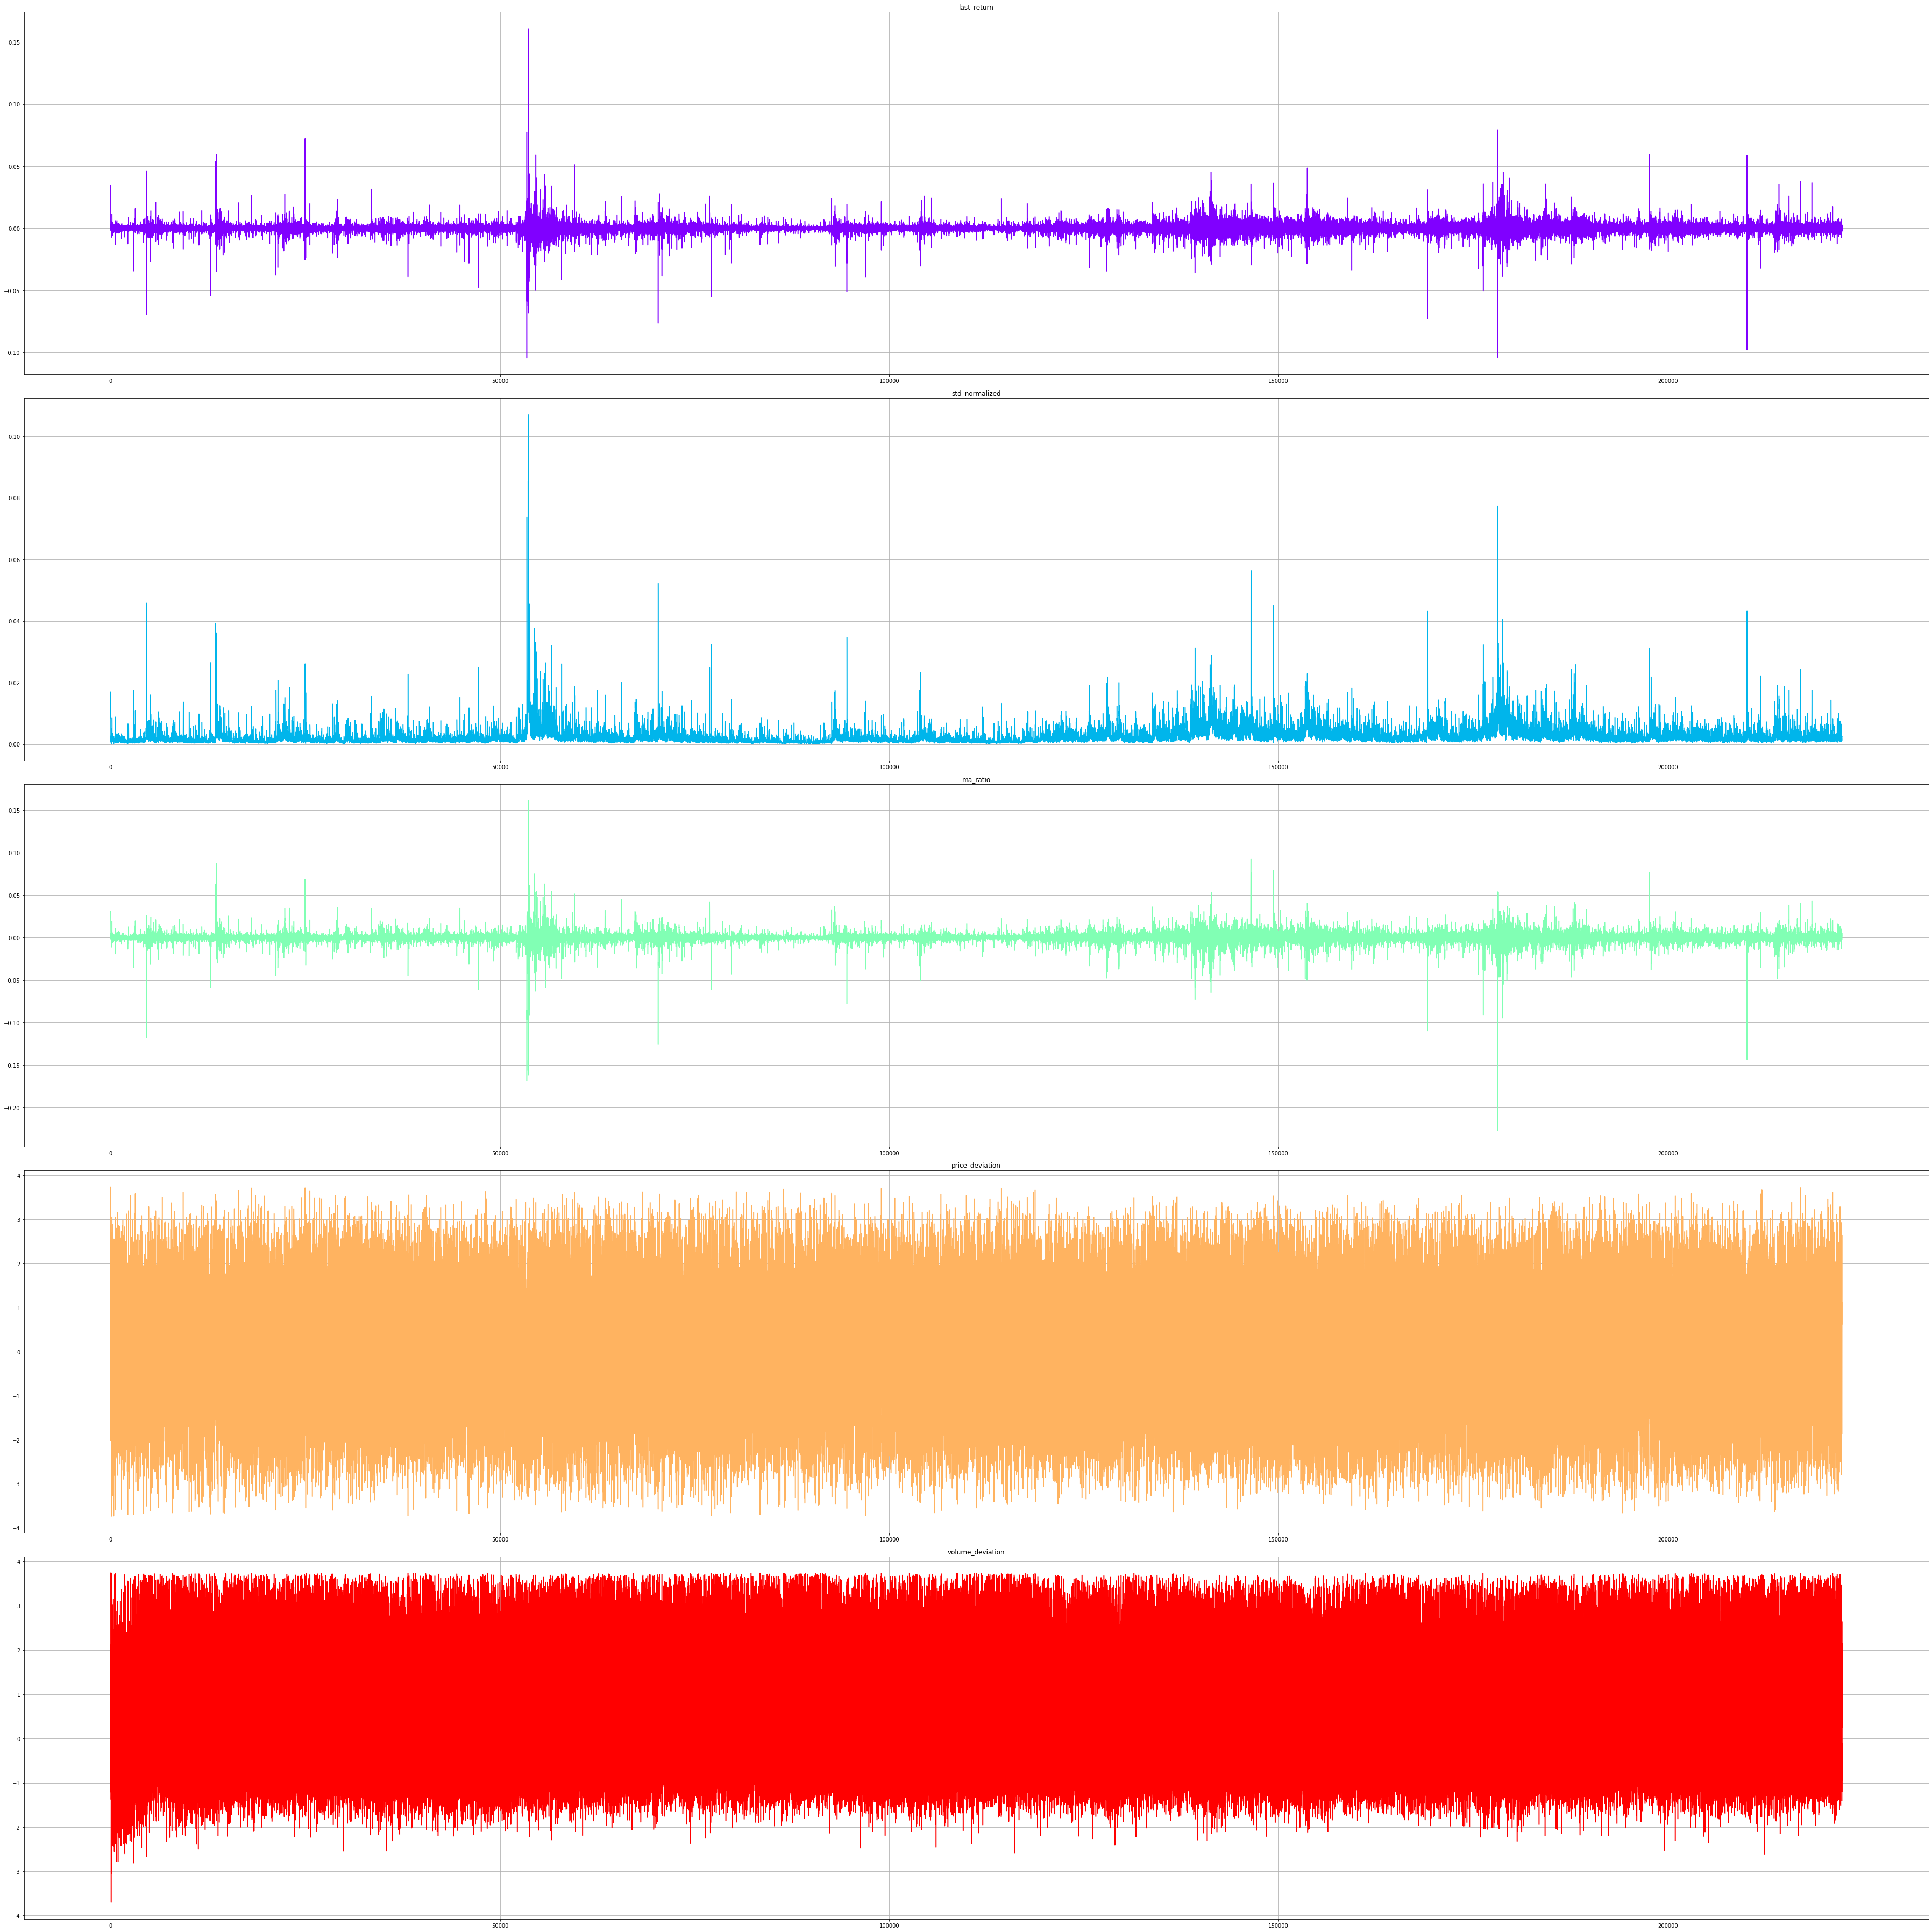

In [43]:
plt.figure(figsize=(20,100))
fig, axs = plt.subplots(len(cols_features), 1, figsize = (50,50))
colours = cm.rainbow(np.linspace(0, 1, len(cols_features)))

for i in range(0, len(cols_features)):
    axs[i].plot(res.reset_index()[cols_features[i]], color = colours[i])
    axs[i].set_title(cols_features[i])
    axs[i].grid(True)
    
plt.tight_layout()

# 模型训练 

1、数据集划分

2、模型训练

3、模型融合

In [10]:
x = res[cols_features]
x_train = x[:int(len(x)/4*3)]
x_test = x[int(len(x)/4*3):]

In [22]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222373 entries, 2019-09-08 19:10:00 to 2021-10-19 23:50:00
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   last_return       222373 non-null  float64
 1   std_normalized    222373 non-null  float64
 2   ma_ratio          222373 non-null  float64
 3   price_deviation   222373 non-null  float64
 4   volume_deviation  222373 non-null  float64
dtypes: float64(5)
memory usage: 10.2+ MB


In [11]:
# 这里训练模型
def get_best_hmm_model(x_train, x_test, max_states, max_iter=20000):
    """
        Train Model and return best model
    """
    best_score = -(10**10)
    best_state = 0
    
    for state in range(1, max_states + 1):
        hmm_model = GaussianHMM(n_components=state, random_state=100,
                               covariance_type='diag', n_iter=max_iter).fit(x_train)
        
        if hmm_model.score(x_test) > best_score:
            best_score = hmm_model.score(x_test)
            best_state = state
            
    best_model = GaussianHMM(n_components=best_state, random_state=100,
                            covariance_type='diag',n_iter=max_iter).fit(x_train)
    
    return best_model

In [12]:
best_model = get_best_hmm_model(x_train, x_test, 6)

In [15]:
# 存储模型
with open("hmm.pkl", "wb") as file: 
    pickle.dump(best_model, file)

In [ ]:
# 加载模型
with open("filename.pkl", "rb") as file: 
    hmm_model = pickle.load(file)

#### 判断模型是否足够好

1、画出模型输出，查看模型输出的分布情况应当和你预期的分布接近

2、画出模型随时间变化的残差，如果残差随时间变化也存在明显的变化，这暗示着有某些参数未被指定，导致模型没有充分拟合数据

3、将模型效果和基准模型比较，一个最常见的基准模型是时间t的值等于时间t-1的值。如果你的模型甚至比这样一个简单的模型差，那就完全没有应用价值，从模型选择，损失函数，预处理等方面来考虑，不要直接调超参数
   
4、研究你的模型如何处理异常值。一个好的模型应该是忽略这些异常值而不是去拟合它们。如果模型对离群值拟合很好，可能就是过拟合了。

5、进行时间敏感性分析。你需要考虑的是时间序列中的定性相似行为是否会在你的模型中产生相似的结果，也就是我们应当假定模型处理相似的时间模式特征时，会采取相似的做法

#### 用蒙特卡洛模拟来实现参数分布的观察

#### 对每个hidden_state进行分析

In [44]:
def plot_hidden_states(hmm_model, data, x):
    plt.figure(figsize=(50, 50))
    fig, axs = plt.subplots(hmm_model.n_components, 3, figsize=(50, 50))
    colours = cm.prism(np.linspace(0 ,1, hmm_model.n_components))
    hidden_states = hmm_model.predict(x)
    
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax[0].plot(data.index, data['close'], c = 'grey')
        ax[0].plot(data.index[mask], data['close'][mask], '.', c = colour, markersize=0.5)
        ax[0].set_title("{0}th hidden state".format(i))
        ax[0].grid(True)
        
        ax[1].hist(data["future_return"][mask], bins=30)
        ax[1].set_xlim([-0.1, 0.1])
        ax[1].set_title("future return distribution at {0}th hidden state".format(i))
        ax[1].grid(True)
        
        ax[2].plot(data["future_return"][mask].cumsum(), c = colour)
        ax[2].set_title('cummulative future return at {0}th hidden state'.format(i))
        ax[2].grid(True)
    plt.tight_layout()

<Figure size 3600x3600 with 0 Axes>

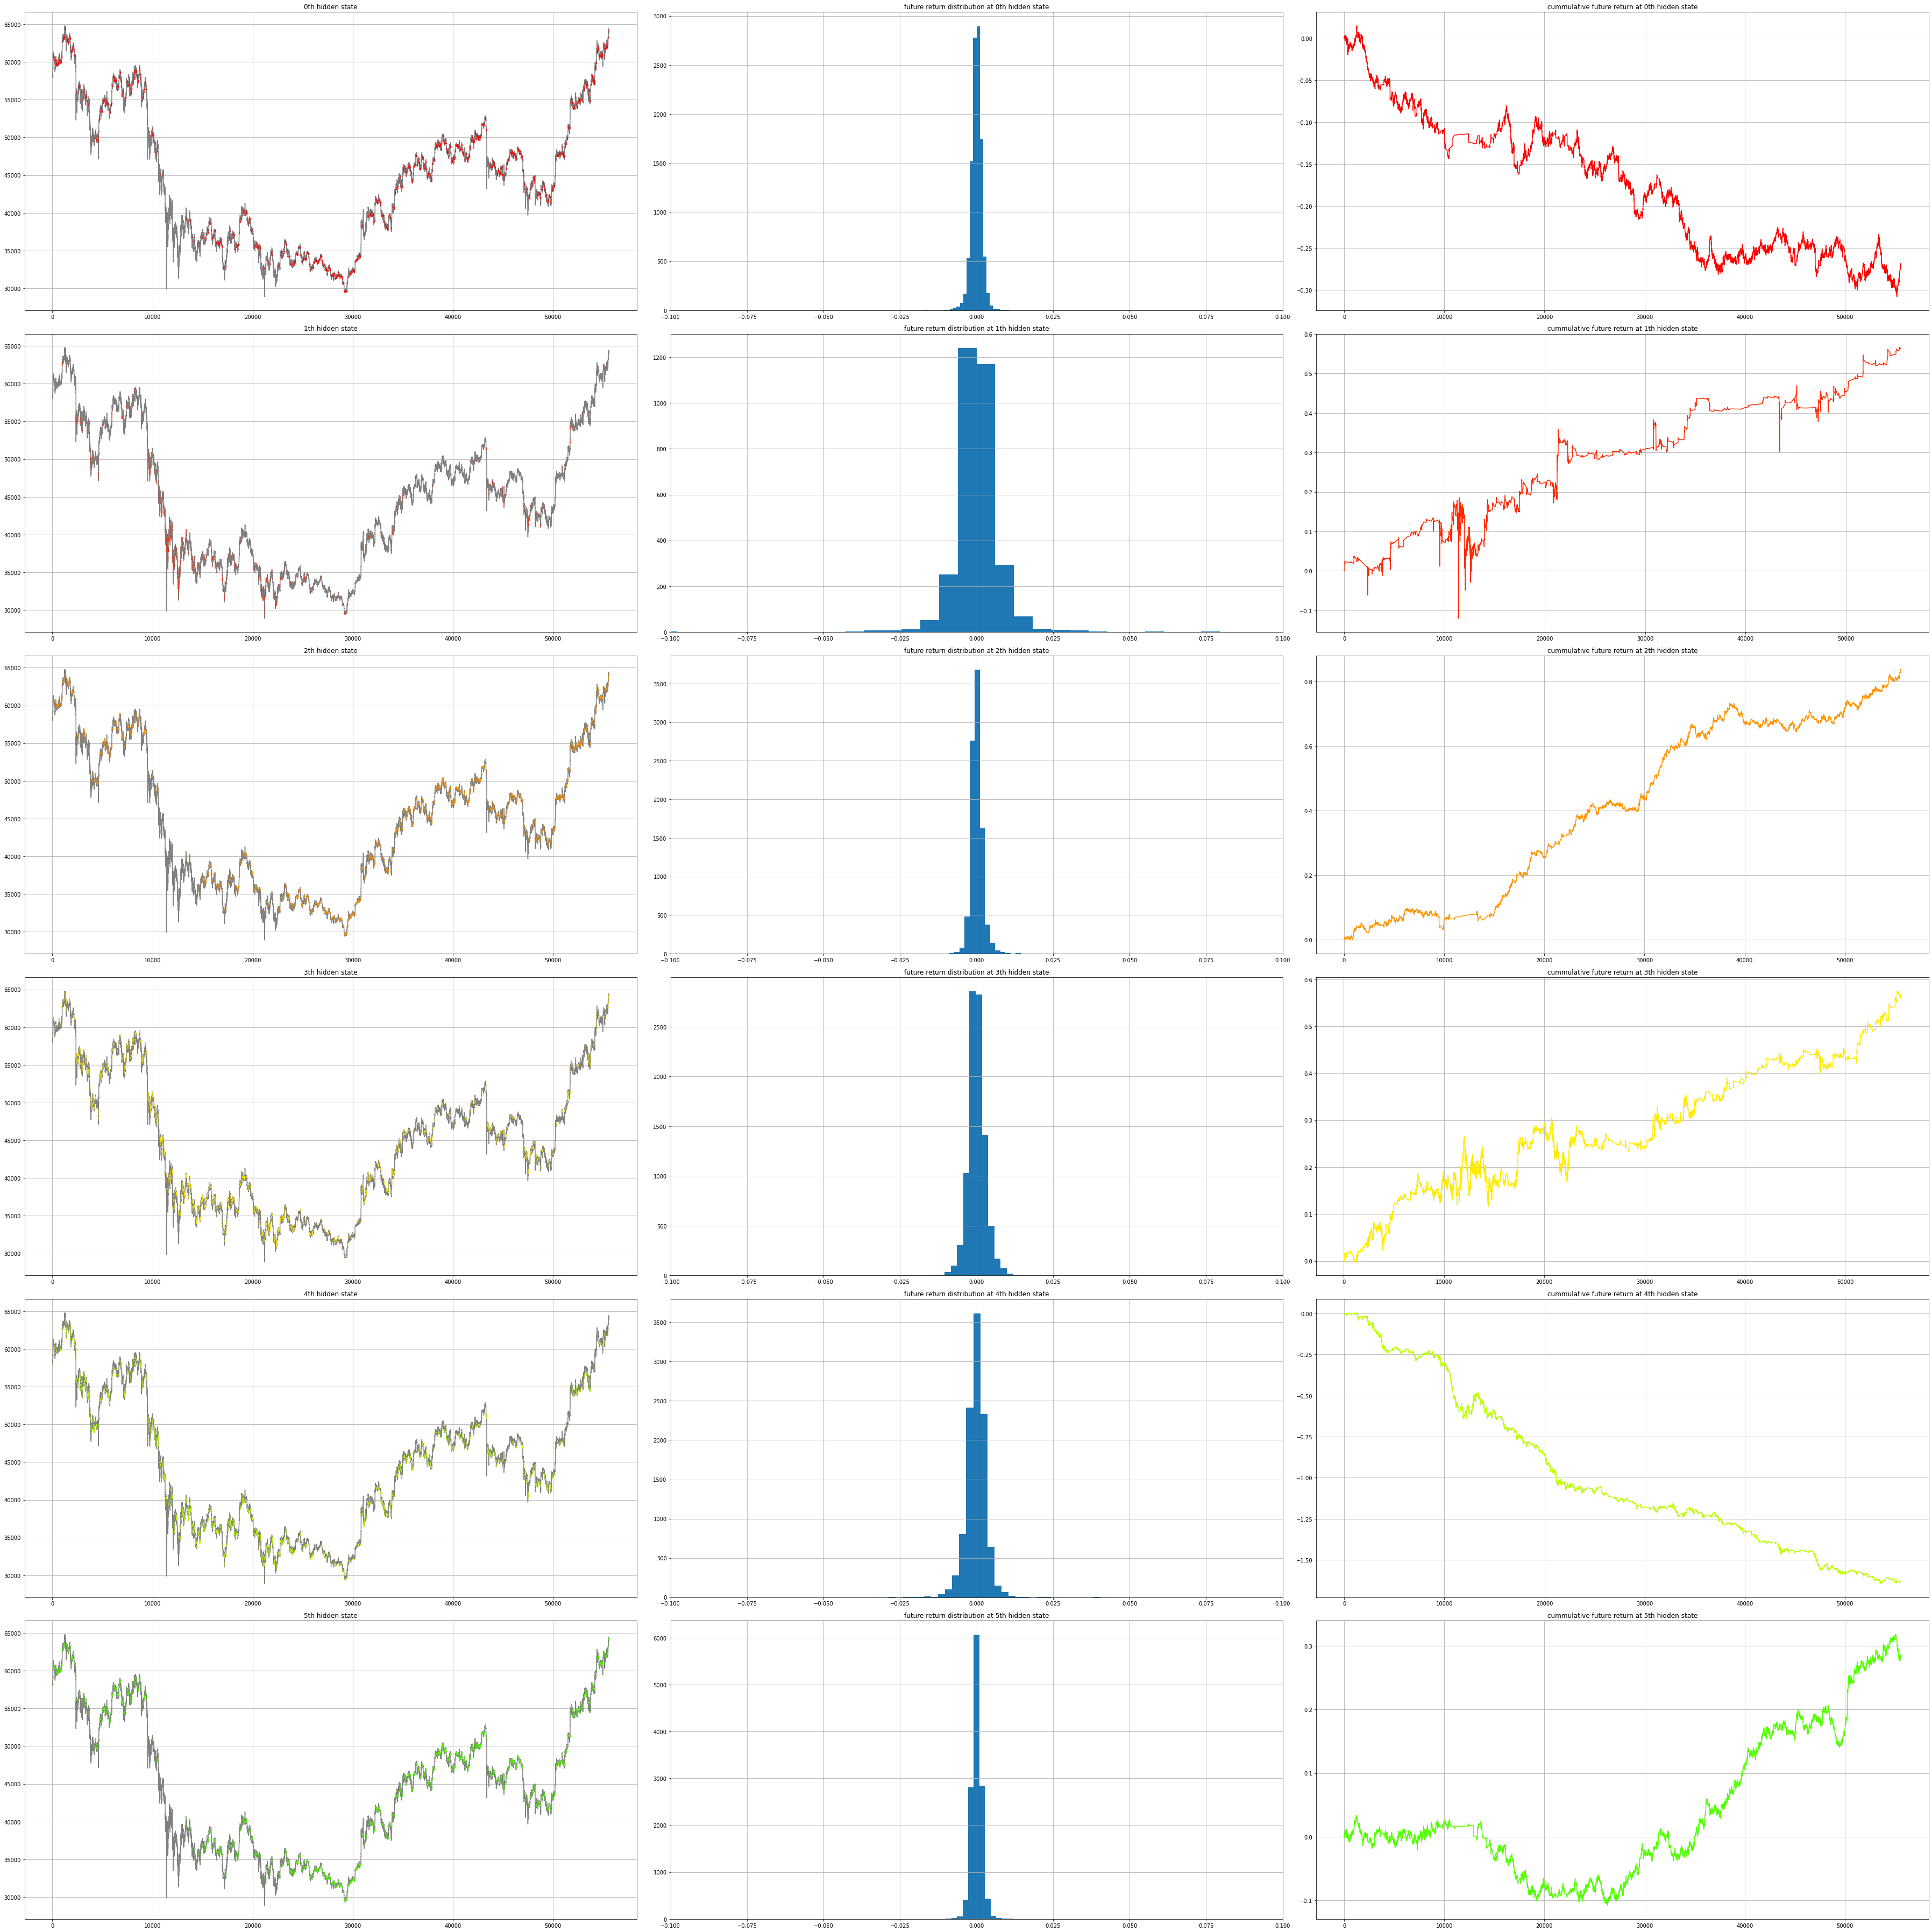

In [47]:
plot_hidden_states(best_model, res[-len(x_test):].reset_index(), x_test)

#### 通过特征来研究每个状态

In [52]:
def mean_confidence_interval(vals, confidence):
    a = 1.0 * np.array(vals)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m - h, m, m + h

In [56]:
def compare_hidden_states(hmm_model, cols_features, conf_interval, iters = 20000):
    plt.figure(figsize=(50, 50))
    
    fig, axs = plt.subplots(len(cols_features), hmm_model.n_components, figsize = (50, 50))
    colours = cm.prism(np.linspace(0, 1, hmm_model.n_components))
    
    for i in range(0 , hmm_model.n_components):
        mc_df = pd.DataFrame()
        
        # Sample generation
        for j in range(0, iters):
            row = np.transpose(hmm_model._generate_sample_from_state(i))
            mc_df = mc_df.append(pd.DataFrame(row).T)
        mc_df.columns = cols_features
        
        for k in range(0, len(mc_df.columns)):
            axs[k][i].hist(mc_df[cols_features[k]], color = colours[i])
            axs[k][i].set_title(cols_features[k] + "(state" + str(i) + "):"
                               + str(np.round(mean_confidence_interval(mc_df[cols_features[k]], conf_interval), 3)))
            
            axs[k][i].grid(True)
        plt.tight_layout()

<Figure size 3600x3600 with 0 Axes>

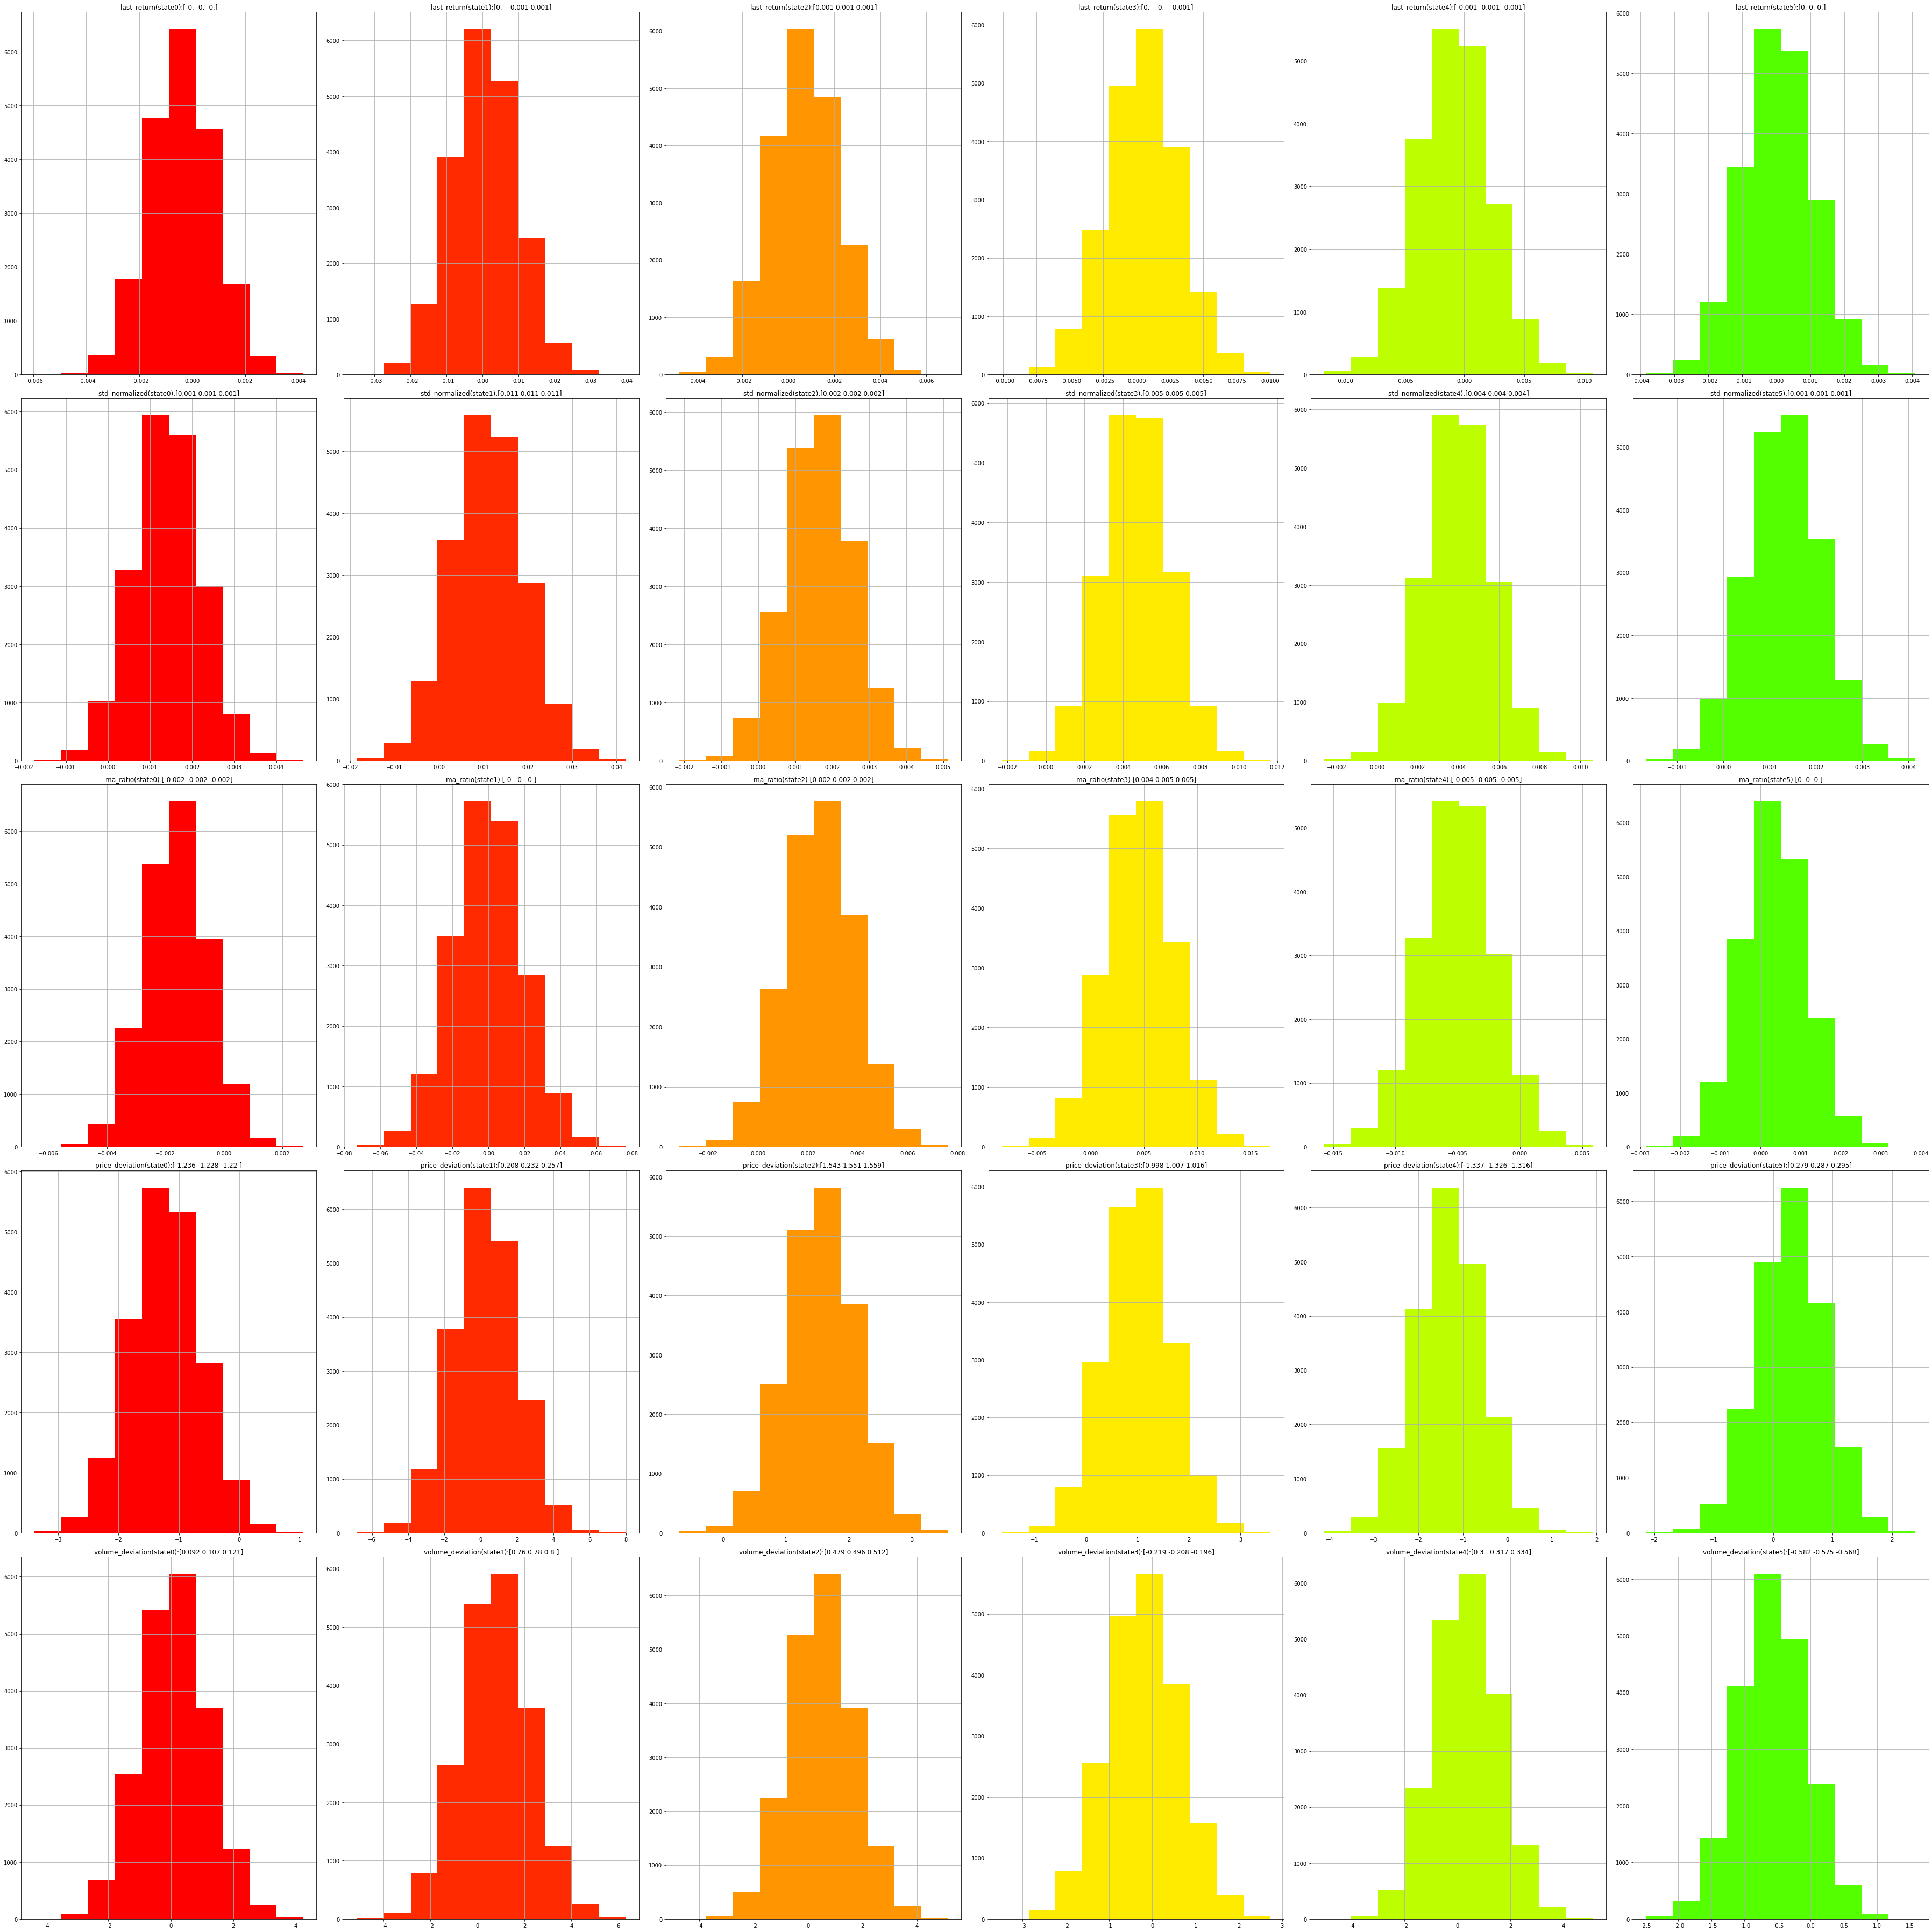

In [57]:
compare_hidden_states(best_model, cols_features, 0.95)

# 模型融合 

从上一步得到的分析结果来看每个状态代表的含义，用hidden state为2、3、4、5、6、7等分别训练模型（可以用不同特征），
将训练得到的模型做bagging

In [89]:
model_two_hidden_states = get_best_hmm_model(x_train, x_test, 2)
model_three_hidden_states = get_best_hmm_model(x_train, x_test, 3)
model_four_hidden_states = get_best_hmm_model(x_train, x_test, 4)
model_five_hidden_states = get_best_hmm_model(x_train, x_test, 5)
model_six_hidden_states = get_best_hmm_model(x_train, x_test, 6)
model_seven_hidden_states = get_best_hmm_model(x_train, x_test, 7)

# 这里先做bagging




# 特征优化

在这里对特征进行组合

后续考虑用深度model提取特征